<a href="https://colab.research.google.com/github/BangachevKiril/RepresentationLearningTheory/blob/plottingbranch/Copy_of_ImageNetEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for experiments with SigLIP
by Kiril Bangachev, Guy Bresler, Iliyas Noman, and Yury Polyanskiy

The original SigLIP was developed in [this paper by Google DeepMind](https://arxiv.org/abs/2303.15343).

The experiments reflect the paper [by Bangachev, Breslr, Noman, Polyanksiy.](tbd) and use the ImageNet validation dataset.

## 0. Imports

In [1]:
from datasets import load_dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import torchvision

In [16]:
# optional. This is toconveniently save embeddings once processed if necessary
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Get data and preprocess

In [3]:
!mkdir ImageNetVal

In [4]:
# downloading imagenet data. With a fast internet and download speed of 15MB/s should take about 7 mins.
%cd ImageNetVal
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

/content/ImageNetVal
--2025-09-10 00:42:19--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6744924160 (6.3G) [application/x-tar]
Saving to: ‘ILSVRC2012_img_val.tar’

ILSVRC2012_img_val. 100%[===================>]   6.28G  47.7MB/s    in 3m 20s  

2025-09-10 00:45:40 (32.1 MB/s) - ‘ILSVRC2012_img_val.tar’ saved [6744924160/6744924160]



In [5]:
!mkdir val

In [6]:
# extract
!tar -xvf ILSVRC2012_img_val.tar -C val

Streaming output truncated to the last 5000 lines.
ILSVRC2012_val_00049867.JPEG
ILSVRC2012_val_00049494.JPEG
ILSVRC2012_val_00048672.JPEG
ILSVRC2012_val_00048308.JPEG
ILSVRC2012_val_00047912.JPEG
ILSVRC2012_val_00045841.JPEG
ILSVRC2012_val_00044931.JPEG
ILSVRC2012_val_00044439.JPEG
ILSVRC2012_val_00043527.JPEG
ILSVRC2012_val_00042653.JPEG
ILSVRC2012_val_00042377.JPEG
ILSVRC2012_val_00041405.JPEG
ILSVRC2012_val_00040366.JPEG
ILSVRC2012_val_00035524.JPEG
ILSVRC2012_val_00033710.JPEG
ILSVRC2012_val_00031038.JPEG
ILSVRC2012_val_00030167.JPEG
ILSVRC2012_val_00024859.JPEG
ILSVRC2012_val_00024401.JPEG
ILSVRC2012_val_00023858.JPEG
ILSVRC2012_val_00023793.JPEG
ILSVRC2012_val_00022999.JPEG
ILSVRC2012_val_00021691.JPEG
ILSVRC2012_val_00021616.JPEG
ILSVRC2012_val_00020289.JPEG
ILSVRC2012_val_00019766.JPEG
ILSVRC2012_val_00019701.JPEG
ILSVRC2012_val_00017988.JPEG
ILSVRC2012_val_00017438.JPEG
ILSVRC2012_val_00015230.JPEG
ILSVRC2012_val_00014799.JPEG
ILSVRC2012_val_00014292.JPEG
ILSVRC2012_val_000125

In [8]:
# uses the labels_text.txt file which has a list of labels in English.
labels_lookup = []
with open('labels_text.txt', 'r') as f:
  for line in f:
    labels_lookup.append(line.split('\n')[0])

In [9]:
# split the ImageNet dataset based on classes
import shutil

# Paths
val_dir = "val"                          # folder with 50k images
mapping_file = "labels_text.txt"         # class labels
output_dir = "val_unpacked"              # where we unpack into 998 folders (two classes have 100 instead of 50 images)

# Create output folder
os.makedirs(output_dir, exist_ok=True)

# Read mapping
with open(mapping_file, "r") as f:
    lines = f.readlines()

for i,line in enumerate(lines):
    filename = 'ILSVRC2012_val_000' +'0'*(5-len(str(i+1))) + str(i+1) + '.JPEG'
    src = os.path.join(val_dir, filename)
    dst_dir = os.path.join(output_dir, str(line.split('\n')[0]))
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, filename)
    shutil.move(src, dst)

print("Done! Validation set organized into 1000 folders.")

Done! Validation set organized into 1000 folders.


## 2. Embed

In [10]:
# get libraries necessary for Hugging Face models
!pip install -U transformers
import requests
from transformers import AutoProcessor, AutoModel

In [11]:
# get model and processor from Hugging Face. See https://huggingface.co/spaces?search=google/siglip-
variety = 'siglip-base-patch16-224' # This is a base model with .2B params that requires 224 x 224 images
model = AutoModel.from_pretrained("google/" + variety).to('cuda')
processor = AutoProcessor.from_pretrained("google/" + variety)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [12]:
# embed finally! On a single A100 should take about 6-7 mins. Can probably be reduced with larger batch sizes
# current batches are single class batches,so around 50 each. Something ike 200 may do better
dim = 768 # dimension of each mage
num = 50000 # number of images
image_embeddings = np.zeros((num, dim))
text_embeddings = np.zeros((num, dim))
splits = [] # index of first instance of each class
ordered_labels = []
folder_path = "val_unpacked"  # Use val_unpacked as the images were moved there
files_in_folder = os.listdir(folder_path)
so_far = 0
for i,label in enumerate(os.listdir('val_unpacked')):
  with torch.no_grad(): #no grad computations plz
    images = [Image.open('val_unpacked/'+label + '/' + filename ).convert('RGB') for
              filename in os.listdir('val_unpacked/'+label)] # get images
    for _ in os.listdir('val_unpacked/'+label):
      ordered_labels.append(label)
    inputs = processor(images=images, text=[label],
                       return_tensors="pt", padding="max_length").to(model.device) # process
    splits.append(so_far)
    outputs = model(**inputs) # forward pass
    #record
    image_embeddings[so_far: so_far + len(images), :] = outputs.image_embeds.detach().cpu().numpy()
    text_embeddings[so_far: so_far + len(images), :] = np.outer(
        np.ones(len(images)), outputs.text_embeds.detach().cpu().numpy())
    so_far += len(images)
  print(i, label, ordered_labels[-1]) # just to have a log that something is happening

0 ice cream ice cream
1 banded gecko banded gecko
2 picket fence picket fence
3 broom broom
4 Cardigan Cardigan
5 cicada cicada
6 American egret American egret
7 hatchet hatchet
8 four-poster four-poster
9 starfish starfish
10 soft-coated wheaten terrier soft-coated wheaten terrier
11 gazelle gazelle
12 patio patio
13 boxer boxer
14 dhole dhole
15 Great Dane Great Dane
16 bathtub bathtub
17 neck brace neck brace
18 spotlight spotlight
19 tiger shark tiger shark
20 ptarmigan ptarmigan
21 Polaroid camera Polaroid camera
22 barbershop barbershop
23 Sussex spaniel Sussex spaniel
24 vault vault
25 microphone microphone
26 gar gar
27 fountain pen fountain pen
28 Arabian camel Arabian camel
29 siamang siamang
30 mixing bowl mixing bowl
31 titi titi
32 confectionery confectionery
33 miniskirt miniskirt
34 lycaenid lycaenid
35 tench tench
36 horizontal bar horizontal bar
37 acoustic guitar acoustic guitar
38 borzoi borzoi
39 bloodhound bloodhound
40 indigo bunting indigo bunting
41 Lhasa Lhasa


In [17]:
%cd ..

/content


In [18]:
# optional, save embedinsg in drive
splits = np.array(splits)
ordered_labels = np.array(ordered_labels)
np.savez('drive/My Drive/Research/SigLIP/imagenetval_siglip_base_patch16_224.npz',
         text = text_embeddings,
         image = image_embeddings,
         splits = splits,
         ordered_labels= ordered_labels)

## 3. Experiments

### 3.1 IP Separation
Tets that embeddinsg are nearly a constelation

In [19]:
unique_texts = text_embeddings[splits]
unique_texts.shape

(998, 768)

In [20]:
ips  = image_embeddings @ unique_texts.T

In [21]:
# can certainly be optimized but 12 secs is not the worst..
matching = []
nonmatching = []
c = 0
for i in range(ips.shape[0]):
  if c+1<len(splits) and splits[c+1] == i:
    c +=1
  for j in range(ips.shape[1]):
    if c == j:
      matching.append(ips[i, j])
    else:
      nonmatching.append(ips[i,j])

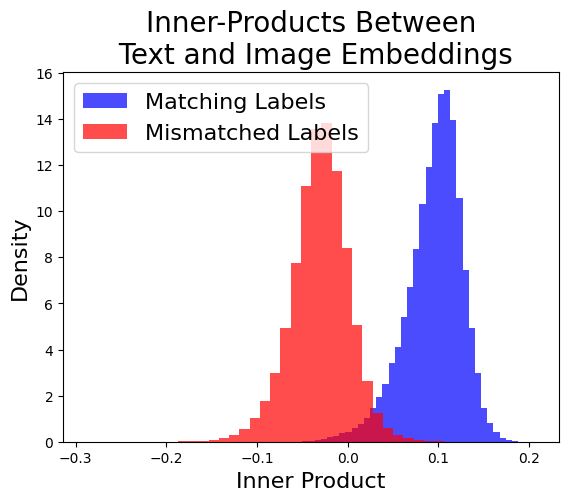

In [23]:
# Give it a minute or two. It's histogramming 5,000,000 data points...

# Create the density histogram
plt.hist(matching, bins=40, color='blue', alpha=0.7, label='Matching Labels', density=True)
plt.hist(nonmatching, bins=40, color='red', alpha=0.7, label='Mismatched Labels', density=True)

# Customize the plot
plt.title('Inner-Products Between\n Text and Image Embeddings', fontsize = 20)
plt.xlabel('Inner Product', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.legend(fontsize = 16)

# Show the plot
plt.savefig('drive/My Drive/Research/SigLIP/figs/imagenetval_siglip_base_patch16_224_ips.png',
            bbox_inches='tight', dpi = 300)
plt.show()

### 3.2 Modality gap

In [24]:
from sklearn.linear_model import Perceptron

In [25]:
representations = np.concatenate([image_embeddings, text_embeddings])
modality = np.concatenate([-np.ones(image_embeddings.shape[0]), np.ones(image_embeddings.shape[0])])

In [26]:
classifier = Perceptron(fit_intercept=True)
classifier.fit(representations,modality)

Perceptron()

In [27]:
predicted = np.matmul(representations, classifier.coef_.reshape(classifier.coef_.shape[-1])) + classifier.intercept_
predicted_text = predicted[modality == 1]
predicted_image = predicted[modality == -1]

In [28]:
print("Misclassifed text: ",np.sum(predicted_text < 0))
print("Misclassifed images: ",np.sum(predicted_image > 0))

Misclassifed text:  0
Misclassifed images:  0


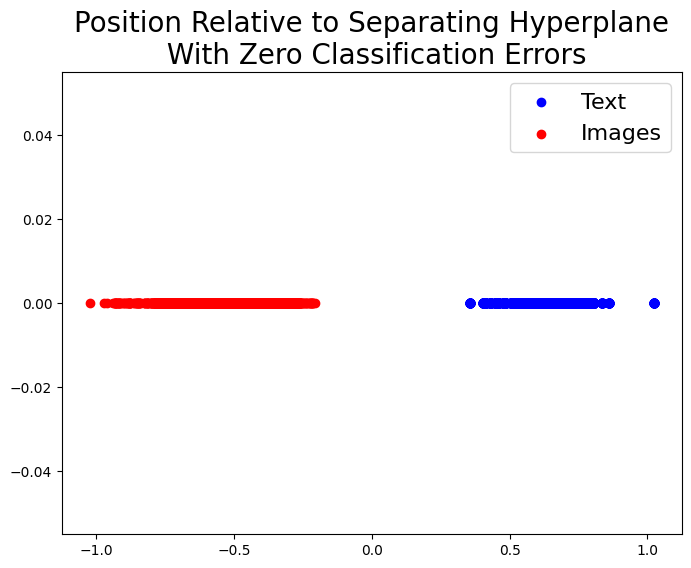

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Plot class 1 data in blue
plt.scatter(predicted_text, np.zeros_like(predicted_text), color='blue', label='Text')

# Plot class 2 data in red
plt.scatter(predicted_image, np.zeros_like(predicted_image), color='red', label='Images')

# Customize the plot (optional)
plt.title('Position Relative to Separating Hyperplane\n With Zero Classification Errors', fontsize = 20)
plt.legend(fontsize = 16)

# Show the plot
plt.savefig('drive/My Drive/Research/SigLIP/figs/imagenetval_siglip_base_patch16_224_mg.png',
            bbox_inches='tight', dpi = 300)
plt.show()

### 3.3. Misclassification

In [50]:
classified_as = np.argmax(ips, axis = 1)
c = 0
total = 0
for i in range(ips.shape[0]):
  if c+1 < len(splits)-1 and i >=splits[c+1]:
    c+=1
  if c!=classified_as[i]:
    # print(ordered_labels[i], ordered_labels[classified_as[i]])
    total +=1
print(total/ips.shape[0])

0.28388


### 3.4 Loss computation

In [84]:
b = model.logit_bias.item()
t = np.e**model.logit_scale.item()
print('Learnt bias : ',b)
print('Learnt temperature : ',t)
print('Relaive bas : ',b/t)

Learnt bias :  -12.9324369430542
Learnt temperature :  117.33076593592128
Relaive bas :  -0.11022204483108111


In [71]:
def loss(ip, matches):
  return np.log(1 + np.e**(-matches*(t*ip - b)))

In [75]:
loss_positive = []
loss_negative = []
for i in range(ips.shape[0]):
  if c+1 < len(splits)-1 and i >=splits[c+1]:
    c+=1
  for j in range(ips.shape[1]):
    if c == j:
      loss_positive.append(loss(ips[i, j], matches= 1))
    else:
      loss_negative.append(loss(ips[i,j], matches = -1))

In [81]:
mean_positive = np.mean(loss_positive)
mean_negative = np.mean(loss_negative)
mean_negative_truncate = np.mean(np.sort(loss_negative)[:int(.8*len(loss_negative))])
print('Mean positive :',mean_positive)
print('Mean negative :',mean_negative)

Mean positive : 0.6407748492764445
Mean negative : 9.412878926105721
